<a href="https://colab.research.google.com/github/AdarshSingh001/Recommendation-System/blob/main/Amazon_fashion_discovery_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing all the neccessary packages

In [ ]:
# all the necessary packagess
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [ ]:
# loading the data using pandas
data = pd.read_json("/content/drive/MyDrive/16k_images-20211027T043303Z-001/misc_files/tops_fashion.json")

In [ ]:
print("number of data points: ", data.shape[0])
print("number of features: ", data.shape[1])

number of data points:  183138
number of features:  19


In [ ]:
data.head(3)

,sku,asin,product_type_name,formatted_price,author,color,brand,publisher,availability,reviews,large_image_url,availability_type,small_image_url,editorial_review,title,model,medium_image_url,manufacturer,editorial_reivew
0,None,B016I2TS4W,SHIRT,None,None,None,FNC7C,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Women's O Nec...,Minions Como Superheroes Ironman Long Sleeve R...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
1,None,B01N49AI08,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Izo Tunic,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
2,None,B01JDPCOHO,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Won Top,None,https://images-na.ssl-images-amazon.com/images...,None,NaN


In [ ]:
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

of these 19 features, we will be only using 6 total features for our this project

asin : Amazon Standard identification number

In [ ]:
data = data[["asin", "brand", "color", "product_type_name", "medium_image_url", "title", "formatted_price"]]
data.head(3)

,asin,brand,color,product_type_name,medium_image_url,title,formatted_price
0,B016I2TS4W,FNC7C,None,SHIRT,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,SHIRT,https://images-na.ssl-images-amazon.com/images...,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,SHIRT,https://images-na.ssl-images-amazon.com/images...,FIG Clothing Womens Won Top,None


we have avoided description because they are lengthy and thus will take significantly longer time to process.

# Missing data in various features

basic stats for feature: product_type_name

In [ ]:
data['product_type_name'].describe()
# we have total 72 types of product type names
# top most product found is shirt, it present around in 167794/183138=91.62 percent of the rows
# we searched using Amazon's api with keyword women's top, so ofcourse there would be presence of large percentage of shirts

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object

In [ ]:
data["product_type_name"].unique()
# will get all the unique data point in the specified feature column

array(['SHIRT', 'SWEATER', 'APPAREL', 'OUTDOOR_RECREATION_PRODUCT',
       'BOOKS_1973_AND_LATER', 'PANTS', 'HAT', 'SPORTING_GOODS', 'DRESS',
       'UNDERWEAR', 'SKIRT', 'OUTERWEAR', 'BRA', 'ACCESSORY',
       'ART_SUPPLIES', 'SLEEPWEAR', 'ORCA_SHIRT', 'HANDBAG',
       'PET_SUPPLIES', 'SHOES', 'KITCHEN', 'ADULT_COSTUME',
       'HOME_BED_AND_BATH', 'MISC_OTHER', 'BLAZER',
       'HEALTH_PERSONAL_CARE', 'TOYS_AND_GAMES', 'SWIMWEAR',
       'CONSUMER_ELECTRONICS', 'SHORTS', 'HOME', 'AUTO_PART',
       'OFFICE_PRODUCTS', 'ETHNIC_WEAR', 'BEAUTY',
       'INSTRUMENT_PARTS_AND_ACCESSORIES', 'POWERSPORTS_PROTECTIVE_GEAR',
       'SHIRTS', 'ABIS_APPAREL', 'AUTO_ACCESSORY', 'NONAPPARELMISC',
       'TOOLS', 'BABY_PRODUCT', 'SOCKSHOSIERY',
       'POWERSPORTS_RIDING_SHIRT', 'EYEWEAR', 'SUIT', 'OUTDOOR_LIVING',
       'POWERSPORTS_RIDING_JACKET', 'HARDWARE', 'SAFETY_SUPPLY',
       'ABIS_DVD', 'VIDEO_DVD', 'GOLF_CLUB', 'MUSIC_POPULAR_VINYL',
       'HOME_FURNITURE_AND_DECOR', 'TABLET_COMPUTER',

In [ ]:
# find the 10 most frequent product type names
product_type_count = Counter(list(data["product_type_name"]))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

basic stats for the feature: brand

In [ ]:
data["brand"].describe()
# there are 183138 - 182987 = 151 missing values

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object

In [ ]:
brand_count = Counter(list(data["brand"]))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

basic stats for feature: color

In [ ]:
data["color"].describe()
# 7.2% of products are black in color
# 64956 of 183138 products have brand information. that's approx 35.48%

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object

In [ ]:
color_count = Counter(list(data["color"]))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

basic stats for the feature: formatted price

In [ ]:
data["formatted_price"].describe()
# only 28395 products are there with price informtion

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object

In [ ]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

basic stats for the feature: title

In [ ]:
data["title"].describe()
# all of the products have a title
# titles are fairly descriptive of what the product is
# as they are short and informative

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object

* consider products which have information
* data["formatted_price"].isnull() => gives the information about the dataframe row's whihch have null values price == None/null

In [ ]:
data = data.loc[~data["formatted_price"].isnull()]
print("number of data points after eliminating price = NULL :", data.shape[0])

number of data points after eliminating price = NULL : 28395


In [ ]:
# consider products whihc have color information
data = data.loc[~data["color"].isnull()]
print("number of data points after eliminating color=NULL :", data.shape[0])

number of data points after eliminating color=NULL : 28385


**we brought down the number of data points from 183k to 28k**

we are processing only 28k points so that we can process on our local machine in reasonable amount of time.

# Remove near duplicate items

In [ ]:
# find number of products which have duplicate titles.
print(sum(data.duplicated("title")))
# we have 2325 products which have same title but different color

2325


In [ ]:
#Remove all products with very few words in title
data_sorted = data[data["title"].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description: ", data_sorted.shape[0])

After removal of products with short description:  27949


In [ ]:
# sort the whole data based on title (alphabetical order of title)
data_sorted.sort_values("title", inplace=True, ascending=False)
data_sorted.head()

,asin,brand,color,product_type_name,medium_image_url,title,formatted_price
61973,B06Y1KZ2WB,Éclair,Black/Pink,SHIRT,https://images-na.ssl-images-amazon.com/images...,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133820,B010RV33VE,xiaoming,Pink,SHIRT,https://images-na.ssl-images-amazon.com/images...,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81461,B01DDSDLNS,xiaoming,White,SHIRT,https://images-na.ssl-images-amazon.com/images...,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75995,B00X5LYO9Y,xiaoming,Red Anchors,SHIRT,https://images-na.ssl-images-amazon.com/images...,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151570,B00WPJG35K,xiaoming,White,SHIRT,https://images-na.ssl-images-amazon.com/images...,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32


there are titles which differ only in the last few words.


In [ ]:
# iterrows() function will return the index of the row and the row itself in the form of series
indices = []
for i, row in data_sorted.iterrows():
  indices.append(i)

In [ ]:
print(indices)

[61973, 133820, 81461, 75995, 151570, 152506, 76209, 103647, 138588, 95954, 74338, 18905, 60078, 59030, 177229, 22273, 135865, 171318, 44082, 40331, 60603, 56982, 39370, 120006, 8424, 139484, 94413, 167267, 92382, 93518, 101522, 74087, 51286, 35796, 73818, 127730, 37902, 164994, 125784, 129103, 161966, 151598, 100567, 102610, 80880, 74066, 167810, 100898, 86604, 153020, 168828, 97684, 83173, 37290, 17234, 130798, 128762, 38107, 32240, 141241, 37911, 142996, 115660, 163170, 73633, 132135, 42468, 69292, 32217, 169883, 108966, 68893, 115422, 141090, 80785, 92051, 165541, 150090, 163741, 123456, 57588, 116686, 170034, 160212, 144984, 142244, 141432, 118353, 101884, 110314, 140321, 76493, 135579, 85390, 78409, 158069, 148089, 100597, 140457, 137999, 147641, 94653, 120825, 145597, 114795, 98140, 148772, 80202, 113184, 79120, 93161, 86422, 103918, 157939, 99504, 85577, 133860, 77972, 163080, 84198, 143996, 155062, 135226, 80328, 89791, 118521, 98687, 99639, 82053, 115267, 160313, 163797, 1420

In [ ]:
import itertools
stage1_dedupe_asins = []
i=0
j=0
num_data_points = data_sorted.shape[0]
while i< num_data_points and j < num_data_points:
  previous_i = i
  # store the list of words of ith string in "a"
  a = data["title"].loc[indices[i]].split()

  # search for the similiar products sequentially
  j = i+1
  while j<num_data_points:

    # store the list of words of jth string in "b"
    b = data['title'].loc[indices[j]].split()

    # store the maximum length of two strings
    length = max(len(a), len(b))

    # count is used to store the number of words that are matched in both strings
    count = 0

    # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
    # example: a =['a', 'b', 'c', 'd']
    # b = ['a', 'b', 'd']
    # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
    for k in itertools.zip_longest(a, b):
      if(k[0]==k[1]):
        count = count + 1

    # if the number of words in two strings differ by more than 2, we are considering two strings to be different
    # if the number of words in two strings differ by less than 2, we are considering two strings to be same
    if (length - count) > 2:
      stage1_dedupe_asins.append(data_sorted["asin"].loc[indices[i]])
      # start searching for apparels corresponds 2nd strinf
      i=j
      break
    else:
      j = j+1
  if previous_i == i:
    break

In [ ]:
print(stage1_dedupe_asins)

['B06Y1KZ2WB', 'B010RV33VE', 'B01DDSDLNS', 'B00X5LYO9Y', 'B00WPJG35K', 'B00WOB0LHK', 'B014GZY5KK', 'B00WPJHEE4', 'B00X5MLMRA', 'B00WPK4T4G', 'B00X9Z53FU', 'B0711JTVXY', 'B0722WJ5H3', 'B0756RHHHV', 'B074741CW9', 'B01I7ZZYE6', 'B01MPYKVER', 'B071JRW7BN', 'B01F4U0ROO', 'B01IKRKKJU', 'B01LZGDZZT', 'B06X6KCJ6Z', 'B007TVCWO0', 'B007TVCG3W', 'B007TVCVT6', 'B007TVDEG0', 'B007TVDOWO', 'B074RGHJR3', 'B01G6NT5TQ', 'B01NCRI89U', 'B01FOHBTSK', 'B01N9P07NZ', 'B01DSF39WY', 'B01JDO5SLY', 'B01DEJ169W', 'B01EK8OXD2', 'B01D8CH3ME', 'B01DJNN2W2', 'B01DEIBQVG', 'B01C6WOOLA', 'B01DSFNLTA', 'B01E4E3AA4', 'B01FEAMTGI', 'B01FRD1JMC', 'B01FMY30TG', 'B01GP4AILU', 'B01KLJ805Q', 'B01M4P5P38', 'B01LZFOWNE', 'B073184L4N', 'B07318SNBX', 'B073G7Q7TP', 'B074NBXX3J', 'B074RH4HFS', 'B01N37BMUS', 'B01I53HU6K', 'B072QVW1V3', 'B071942WNH', 'B06XDGF4QJ', 'B07558S4B6', 'B0756V1P6M', 'B0756PL923', 'B073N8QLLQ', 'B00YBAI1X8', 'B06ZZMWWH8', 'B074K4NH9D', 'B01LZPCET5', 'B01LXR02UP', 'B01M0ZSWBF', 'B01LXQYX75', 'B01M0CR3NR', 'B01L

In [ ]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

In [ ]:
data.head()

,asin,brand,color,product_type_name,medium_image_url,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,SHIRT,https://images-na.ssl-images-amazon.com/images...,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,SHIRT,https://images-na.ssl-images-amazon.com/images...,Women's Unique 100% Cotton T - Special Olympic...,$9.99
15,B003BSRPB0,FeatherLite,White,SHIRT,https://images-na.ssl-images-amazon.com/images...,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,SHIRT,https://images-na.ssl-images-amazon.com/images...,Supernatural Chibis Sam Dean And Castiel O Nec...,$7.39
43,B0079BMKDS,FeatherLite,White,APPAREL,https://images-na.ssl-images-amazon.com/images...,Featherlite Ladies' Silky Smooth Pique (White)...,$13.53


**we have removed the duplicates which only differ at end and are adjacent**

In [ ]:
print("number of data points: ", data.shape[0])

number of data points:  17592


below code takes about an hour to run, we will be having combinations of every title which we will check whether they are similiar or not!

In [ ]:
# # time complexity is O(n^2)
# # will remove the similiar titles which are not adjacent as well

# indices = []
# for i, row in data.iterrows():
#   indices.append(i)

# stage2_dedupe_asins = []
# while (len(indices)!=0):
#   i = indices.pop()
#   stage2_dedupe_asins.append(data["asin"].loc[i])

#   # consider the first apparel title
#   # store the list of words of ith string in "a"
#   a = data['title'].loc[i].split()

#   for j in indices:
#     # store the list of words of jth string in "b"
#     b = data['title'].loc[j].split()

#     length = max(len(a), len(b))
#     # count is used to store the number of words that are matching in both the strings
#     count = 0

#     for k in itertools.zip_longest(a,b):
#       if (k[0]==k[1]):
#         count = count + 1

#     # if the number of words count in both the title differ by more than 3, we will then consider both the titles to be different
#     # else, we will consider only one of them as they are repetitive
#     if (length - count)<3:
#       indices.remove(j)

# # from all the products we will consider only the products which are found in previous run
# data = data.loc[data["asin"].isin(stage2_dedupe_asins)]

# data.to_pickle('/content/drive/MyDrive/16k_images-20211027T043303Z-001/16k_apperal_data')
# # Storing these products in a pickle file
# # candidates who wants to download these files instead
# # of 180K they can download and use them from the Google Drive folder.

# Text Processing

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/16k_images-20211027T043303Z-001/16k_apperal_data')

In [ ]:
print("number of data points in new dataset: ",data.shape[0])

number of data points in new dataset:  16042


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# we will use the list of stop words that are downloaded from nltk library
stop_words = nltk.corpus.stopwords.words('english')
print("list of stop words: ", stopwords)

def nlp_preprocessing(total_text, index, column):
  if type(total_text) is not int:
    string = ""
    for words in total_text.split():
      # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
      word = ("".join(e for e in words if e.isalnum()))
      # convert all letters to lower case
      word = word.lower()
      # stop words removal
      if not word in stop_words:
        string += word + " "
    data[column][index] = string

list of stop words:  <WordListCorpusReader in '/root/nltk_data/corpora/stopwords'>


In [ ]:
start_time= time.time()
# we take each title and text_preprocess it
for index, row in data.iterrows():
  nlp_preprocessing(row["title"], index, "title")
# print the time it took to preprocess the whole title
print(time.time() - start_time, "seconds")

9.584487438201904 seconds


In [ ]:
data.head(3)

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54


# Stemming

In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem("arguing"))
print(stemmer.stem("fishing"))

argu
fish


we tried using stemming on our title and it didn't work very well

# Text based product similiarity

In [ ]:
data.head(3)

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54


In [ ]:
data["medium_image_url"]

4         https://images-na.ssl-images-amazon.com/images...
6         https://images-na.ssl-images-amazon.com/images...
15        https://images-na.ssl-images-amazon.com/images...
27        https://images-na.ssl-images-amazon.com/images...
46        https://images-na.ssl-images-amazon.com/images...
                                ...                        
183081    https://images-na.ssl-images-amazon.com/images...
183092    https://images-na.ssl-images-amazon.com/images...
183096    https://images-na.ssl-images-amazon.com/images...
183101    https://images-na.ssl-images-amazon.com/images...
183120    https://images-na.ssl-images-amazon.com/images...
Name: medium_image_url, Length: 16042, dtype: object

# Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() # get number of rows and columns in feature matrix

(16042, 12609)

In [ ]:
title_features

<16042x12609 sparse matrix of type '<class 'numpy.int64'>'
	with 147545 stored elements in Compressed Sparse Row format>

utility function which we will use later

In [ ]:
# we will define some utility function

In [ ]:
# display an image
def display_image(url, ax, fig):
  # we get the url of the apparel and download it
  response = requests.get(url)
  url_image=r"16k_images/"+url+".jpeg" #this url is actually the asin value of that row
  img = Image.open(url_image)
  # img = Image.open(BytesIO(response.content))
  # we will display it in notebook
  plt.imshow(img)

# plotting code to understand the algorith's decision
def plot_heatmap(keys, values, labels, url, text):
  # keys: list of words of recommended title
  # values: len(values) == len(keys), values(i) represents the occurence of the word keys(i)
  # labels: len(labels) == len(keys), the values of labels depends on the model we are using
      # if model=="bag of words": labels(i)=values(i)
      # if model=="tfidf weighted bag of words": labels(i) = tfidf(keys(i))
      # if model=="idf weighted bag of words": labels(i) = idf(keys(i))
  # url: apparel's url

  # we will divide the whole figure into two parts
  gs = gridspec.GridSpec(2,2,width_ratios=[4,1],height_ratios=[4,1])
  fig = plt.figure(figsize=(25,3))

  # 1st, plotting heat map that represents the count of commonly occured words in title
  ax = plt.subplot(gs[0])
  # it displays a color in white color if the word is i9(ntersection( list of words of title1 and list of words of title2), in black if not
  ax = sns.heatmap(np.array([values]), annot = np.array([labels]))
  ax.set_xticklabels(keys) # set that axis labels as the words of title
  ax.set_title(text) # apparel title

  # 2nd, plotting image of the apparel
  ax = plt.subplot(gs[1])
  # we don't want any grid lines for image and no labels on x-axis and y-axis
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

  # we call display_img based with parameter url
  display(url, ax, fig)
  # displays combine figure (heat map and image together)
  plt.show()

def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models,
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys())

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0
    values = [vec2[x] for x in vec2.keys()]

    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b

    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

'https://images-na.ssl-images-amazon.com/images/I/51a33K-9qfL._SL160_.jpg'

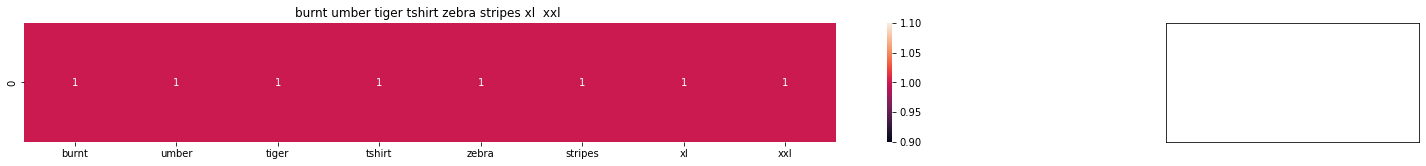

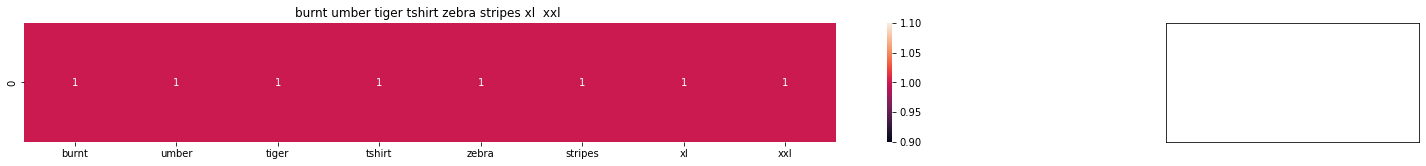

ASIN : B00JXQB5FQ
Brand: Si Row
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 0.0


'https://images-na.ssl-images-amazon.com/images/I/51idp4BP50L._SL160_.jpg'

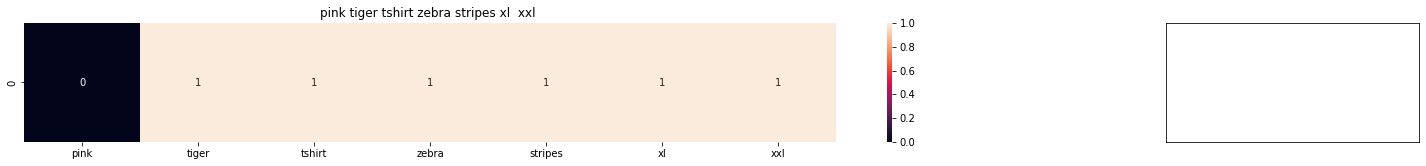

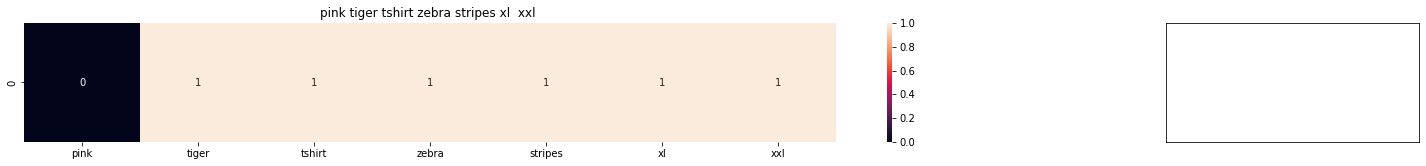

ASIN : B00JXQASS6
Brand: Si Row
Title: pink tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 1.7320508075688772


'https://images-na.ssl-images-amazon.com/images/I/51tOiBaq5FL._SL160_.jpg'

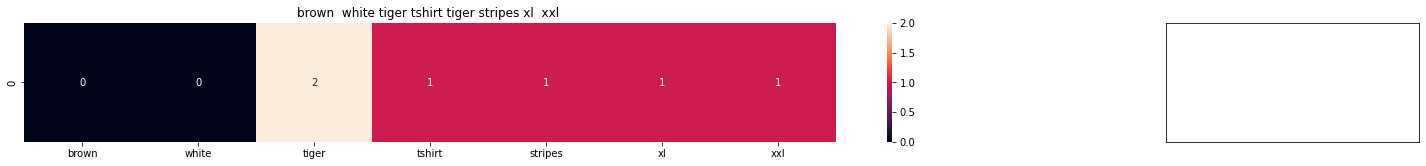

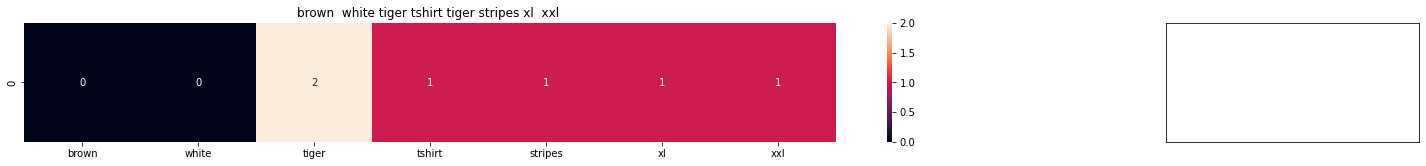

ASIN : B00JXQCWTO
Brand: Si Row
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean similarity with the query image : 2.449489742783178


'https://images-na.ssl-images-amazon.com/images/I/511SmrC%2BS1L._SL160_.jpg'

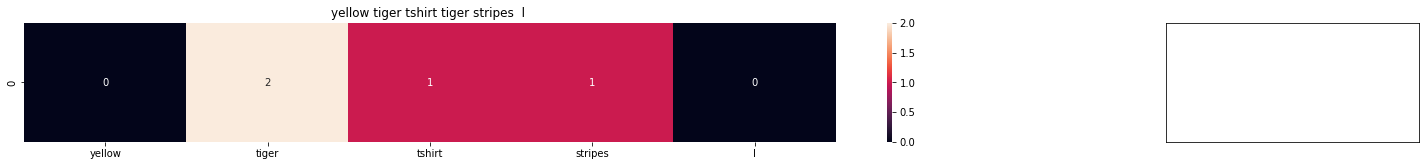

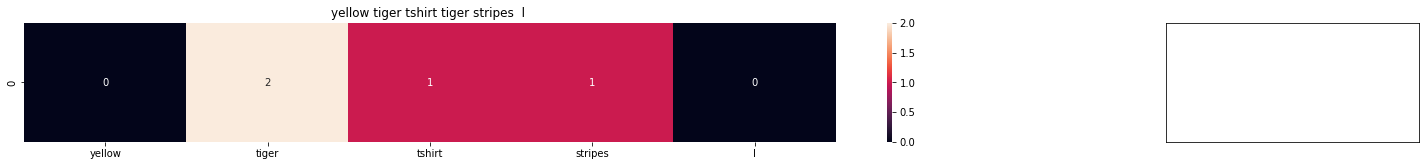

ASIN : B00JXQCUIC
Brand: Si Row
Title: yellow tiger tshirt tiger stripes  l 
Euclidean similarity with the query image : 2.6457513110645907


'https://images-na.ssl-images-amazon.com/images/I/41rrKNq0XfL._SL160_.jpg'

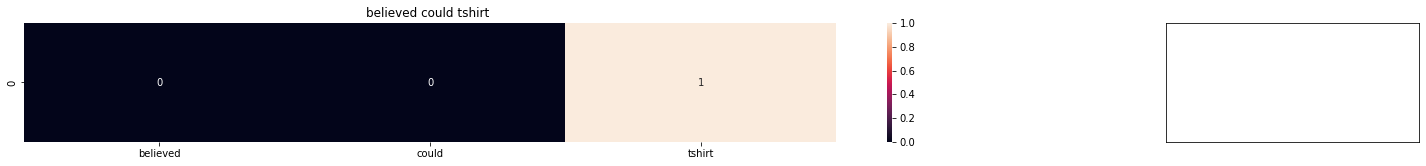

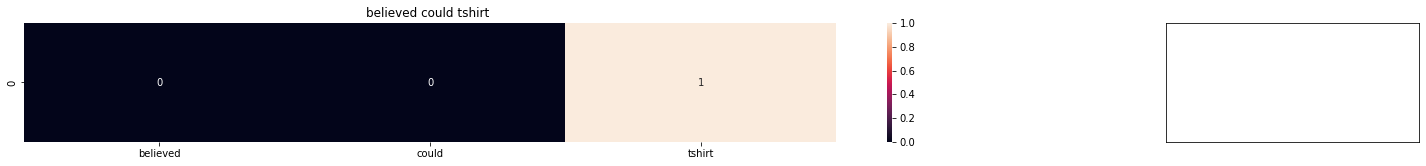

ASIN : B07568NZX4
Brand: Rustic Grace
Title: believed could tshirt 
Euclidean similarity with the query image : 3.0


'https://images-na.ssl-images-amazon.com/images/I/41rOCetj8IL._SL160_.jpg'

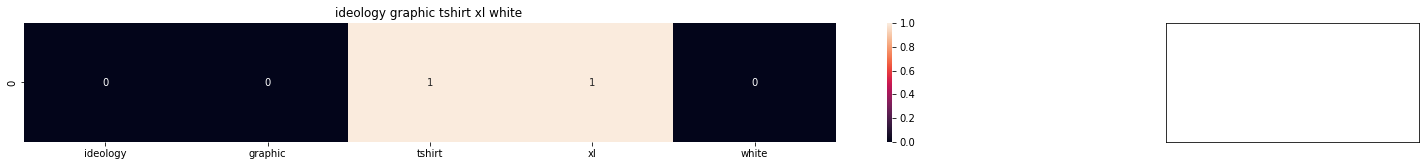

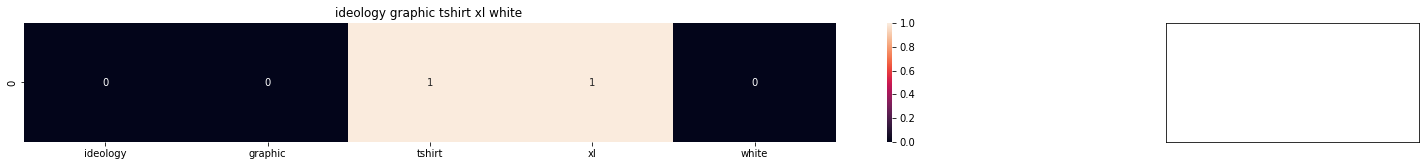

ASIN : B01NB0NKRO
Brand: Ideology
Title: ideology graphic tshirt xl white 
Euclidean similarity with the query image : 3.0


'https://images-na.ssl-images-amazon.com/images/I/51WmlCKqC-L._SL160_.jpg'

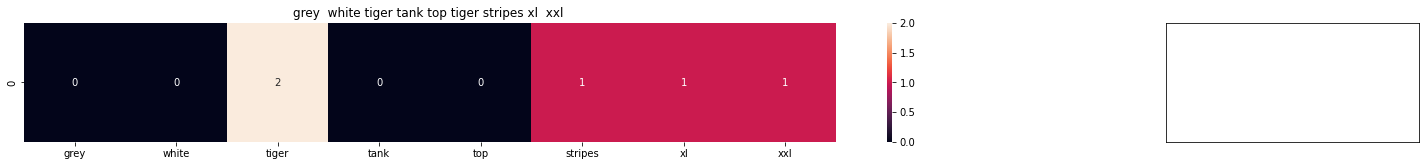

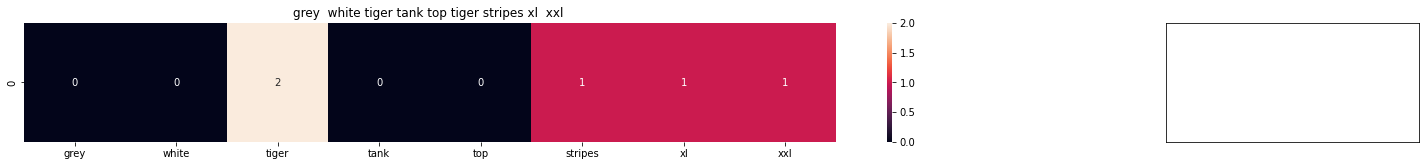

ASIN : B00JXQAFZ2
Brand: Si Row
Title: grey  white tiger tank top tiger stripes xl  xxl 
Euclidean similarity with the query image : 3.0


'https://images-na.ssl-images-amazon.com/images/I/41-aP6B9%2BRL._SL160_.jpg'

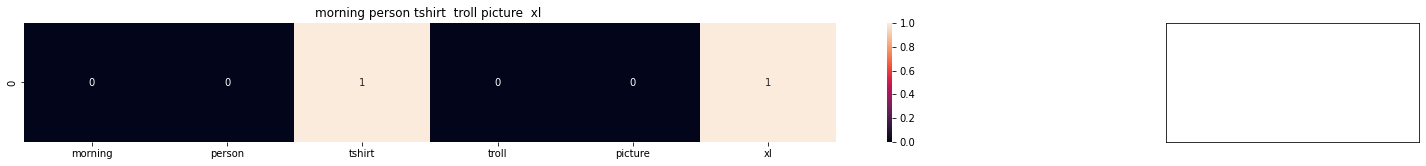

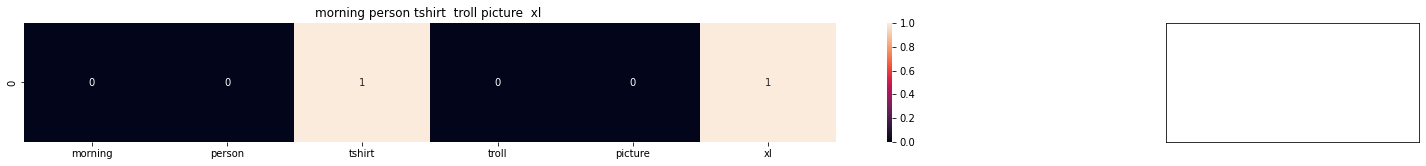

ASIN : B01CLS8LMW
Brand: Awake
Title: morning person tshirt  troll picture  xl 
Euclidean similarity with the query image : 3.1622776601683795


'https://images-na.ssl-images-amazon.com/images/I/41bUreIWVuL._SL160_.jpg'

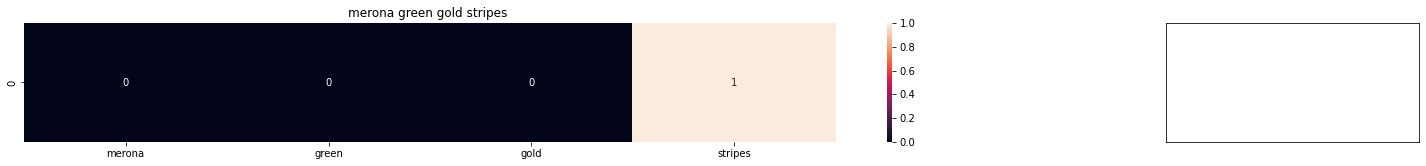

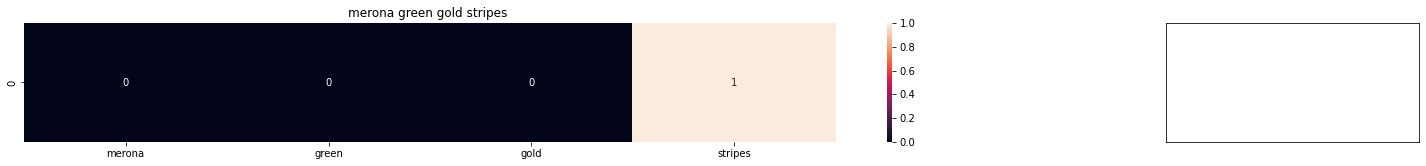

ASIN : B01KVZUB6G
Brand: Merona
Title: merona green gold stripes 
Euclidean similarity with the query image : 3.1622776601683795


'https://images-na.ssl-images-amazon.com/images/I/414Clo9aClL._SL160_.jpg'

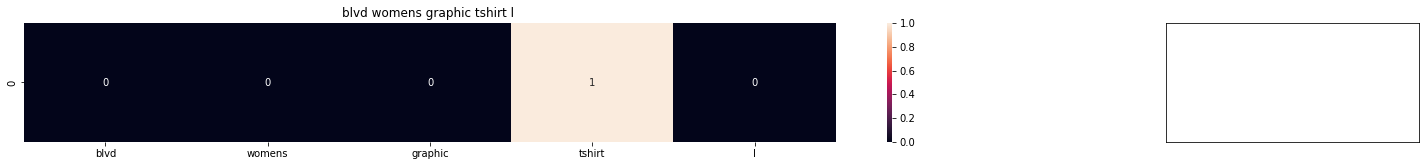

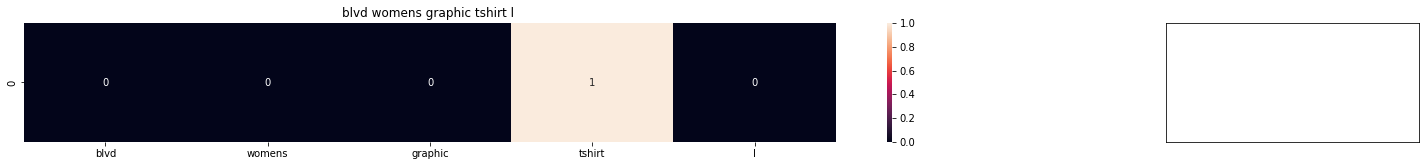

ASIN : B0733R2CJK
Brand: BLVD
Title: blvd womens graphic tshirt l 
Euclidean similarity with the query image : 3.1622776601683795


'https://images-na.ssl-images-amazon.com/images/I/51XBEBD-tUL._SL160_.jpg'

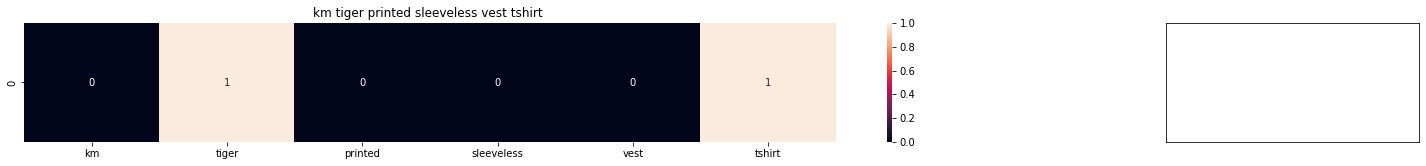

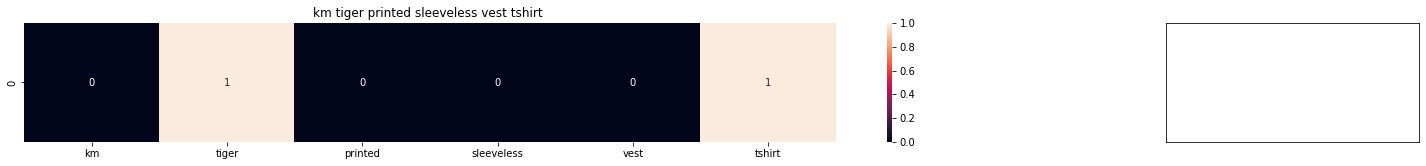

ASIN : B012VQLT6Y
Brand: KM T-shirt
Title: km tiger printed sleeveless vest tshirt 
Euclidean similarity with the query image : 3.1622776601683795


'https://images-na.ssl-images-amazon.com/images/I/51-Iz5leaXL._SL160_.jpg'

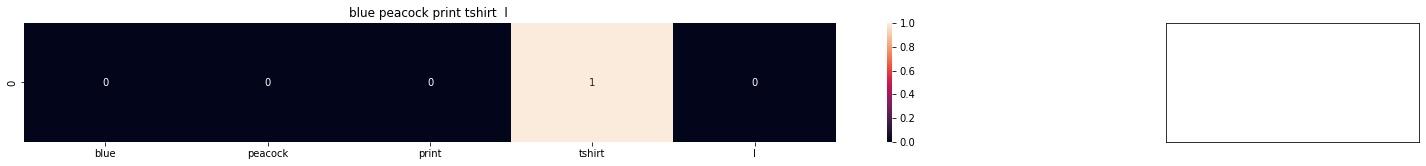

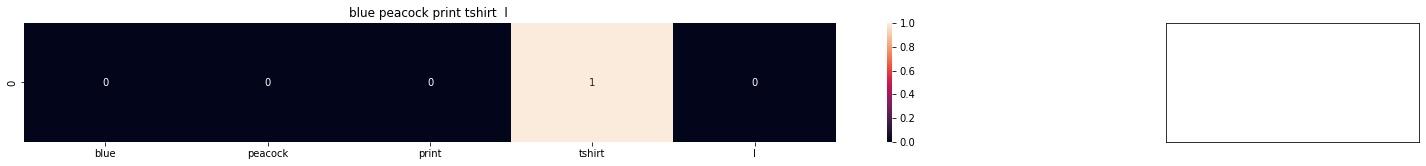

ASIN : B00JXQC8L6
Brand: Si Row
Title: blue peacock print tshirt  l 
Euclidean similarity with the query image : 3.1622776601683795


'https://images-na.ssl-images-amazon.com/images/I/41GQcgTW5vL._SL160_.jpg'

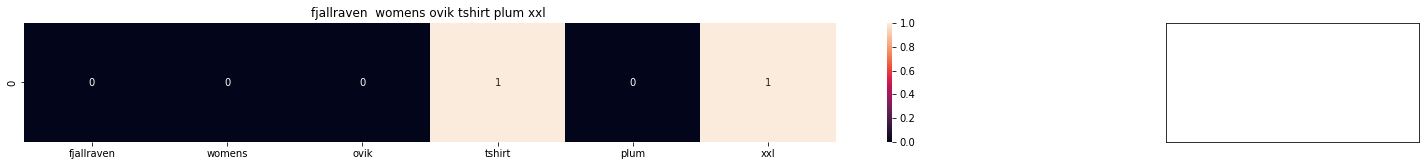

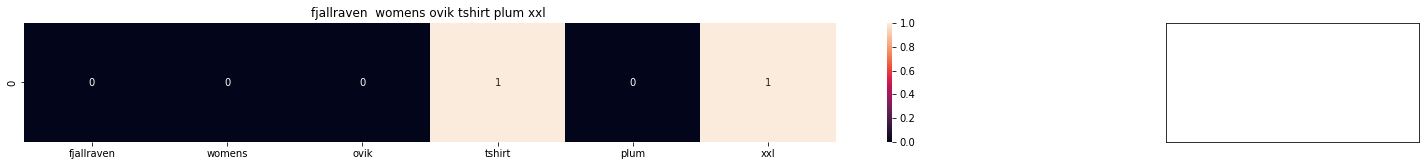

ASIN : B06XC3CZF6
Brand: Fjallraven
Title: fjallraven  womens ovik tshirt plum xxl 
Euclidean similarity with the query image : 3.1622776601683795


'https://images-na.ssl-images-amazon.com/images/I/41krjwD8K-L._SL160_.jpg'

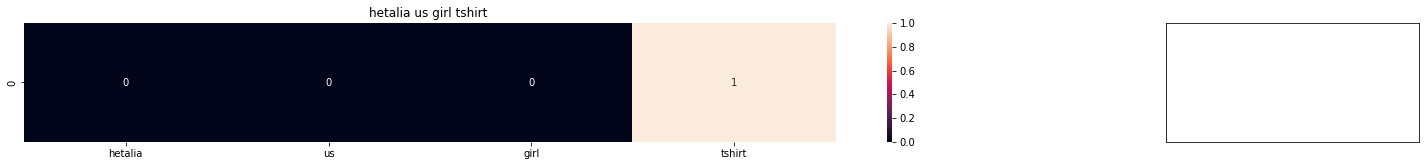

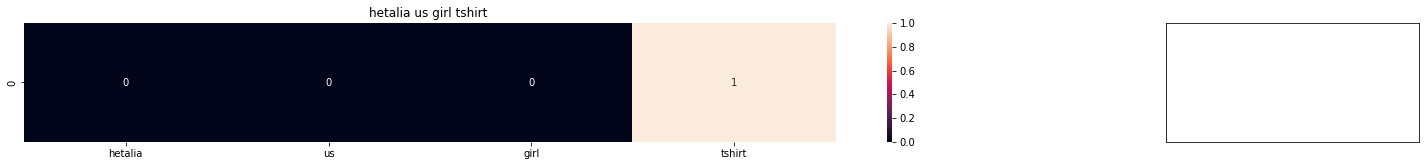

ASIN : B005IT8OBA
Brand: Hetalia
Title: hetalia us girl tshirt 
Euclidean similarity with the query image : 3.1622776601683795


'https://images-na.ssl-images-amazon.com/images/I/41d5PV4fQaL._SL160_.jpg'

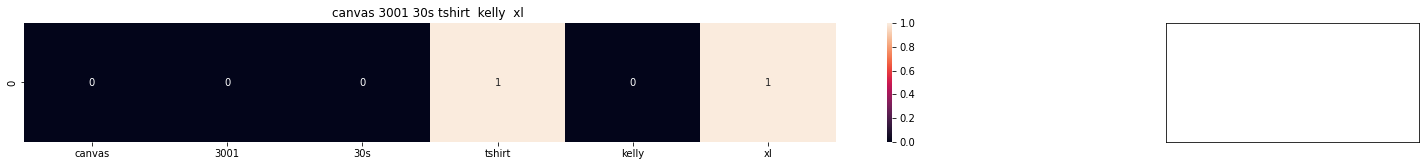

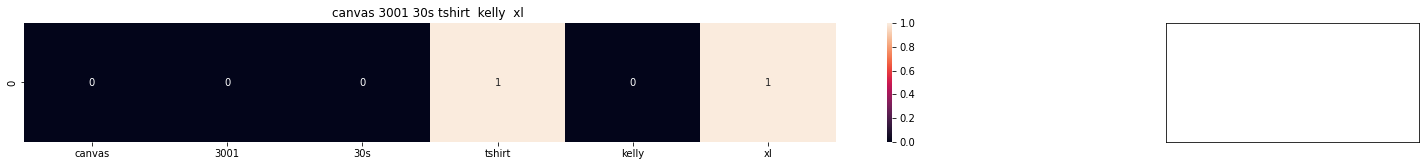

ASIN : B0088PN0LA
Brand: Red House
Title: canvas 3001 30s tshirt  kelly  xl 
Euclidean similarity with the query image : 3.1622776601683795


'https://images-na.ssl-images-amazon.com/images/I/316w0DbBwVL._SL160_.jpg'

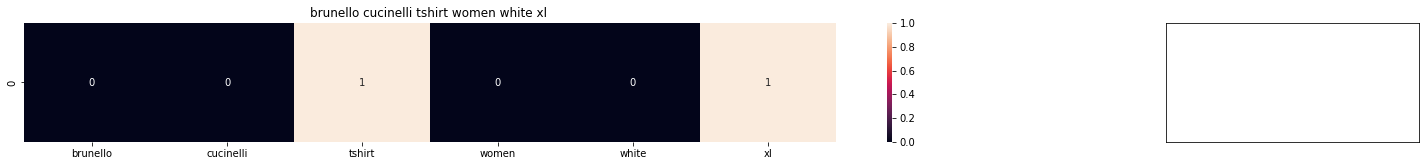

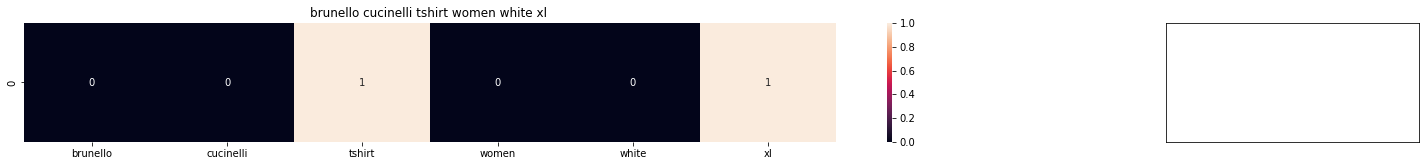

ASIN : B06X99V6WC
Brand: Brunello Cucinelli
Title: brunello cucinelli tshirt women white xl 
Euclidean similarity with the query image : 3.1622776601683795


'https://images-na.ssl-images-amazon.com/images/I/41ZuSXU7a3L._SL160_.jpg'

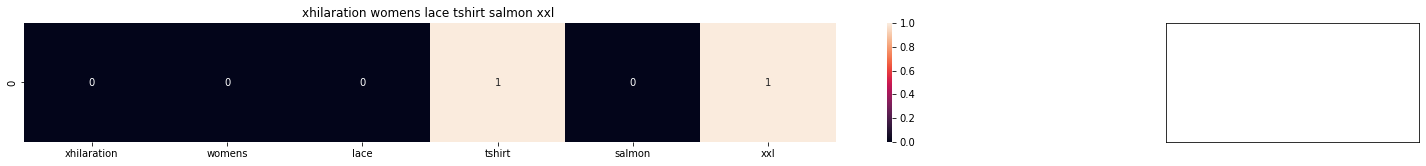

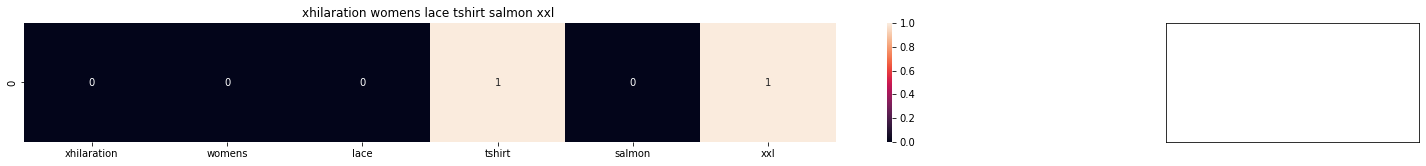

ASIN : B06Y1JPW1Q
Brand: Xhilaration
Title: xhilaration womens lace tshirt salmon xxl 
Euclidean similarity with the query image : 3.1622776601683795


'https://images-na.ssl-images-amazon.com/images/I/51xOzQheo%2BL._SL160_.jpg'

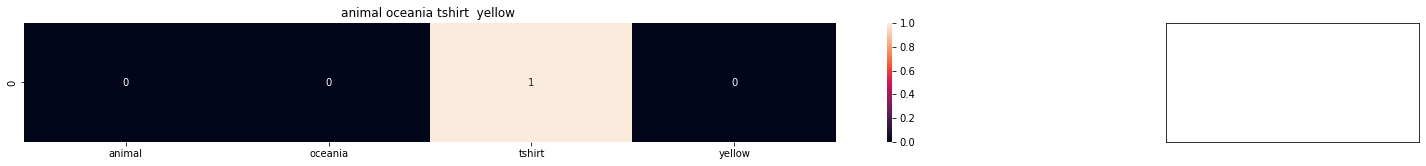

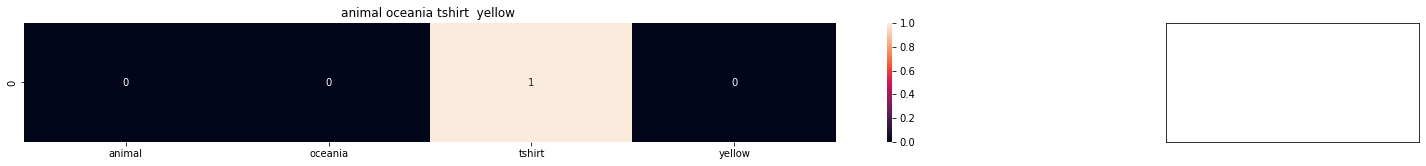

ASIN : B06X6GX6WG
Brand: Animal
Title: animal oceania tshirt  yellow 
Euclidean similarity with the query image : 3.1622776601683795


'https://images-na.ssl-images-amazon.com/images/I/41cwo7hDjeL._SL160_.jpg'

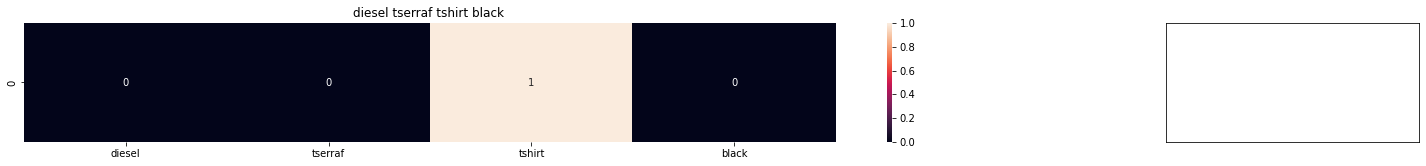

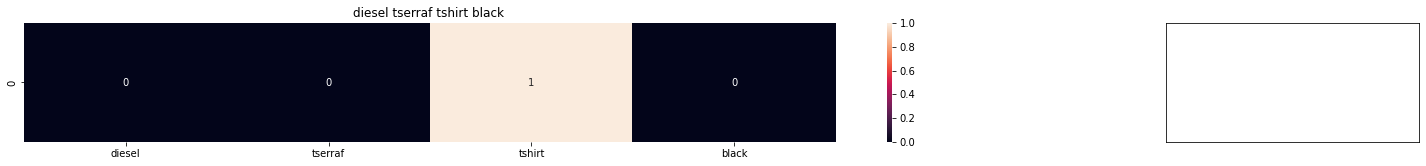

ASIN : B017X8PW9U
Brand: Diesel
Title: diesel tserraf tshirt black 
Euclidean similarity with the query image : 3.1622776601683795


'https://images-na.ssl-images-amazon.com/images/I/41cd6hd0eZL._SL160_.jpg'

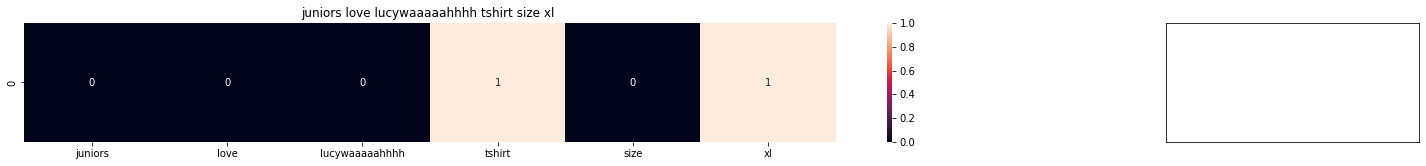

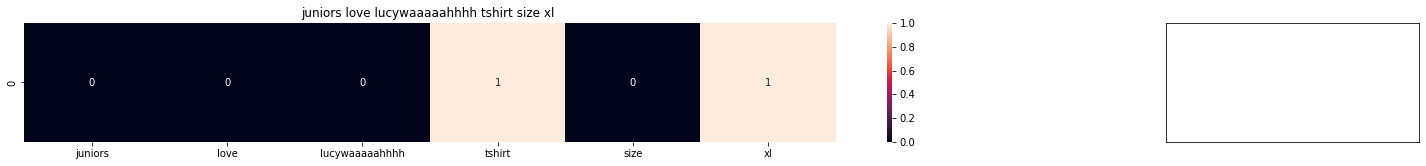

ASIN : B00IAA4JIQ
Brand: I Love Lucy
Title: juniors love lucywaaaaahhhh tshirt size xl 
Euclidean similarity with the query image : 3.1622776601683795


In [ ]:
def bag_of_words_model(doc_id, num_results):
  """
  doc_id: apparel i'd in data
  num_results: number of desired similiar products
  """
  # pairwise_dist will store the distance between the query point to all the point
  pairwise_dist = pairwise_distances(title_features, title_features[doc_id])

  # np.argsort will return the indices of the smallest distances
  indices = np.argsort(pairwise_dist.flatten())[0:num_results]

  # pdists will store the smallest distances
  pdists = np.sort(pairwise_dist.flatten())[0:num_results]

  # dataframe indices of smallest distance's
  df_indices = list(data.index[indices])

  for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(12566, 20) # change the index if you want to.
# In the output heat map each value represents the count value
# of the label word, the color represents the intersection
# with inputs title.


# TD-IDF based product similiartiy

In [ ]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
# tfidf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# tfidf_title_features[doc_id, index_of_word_in_corpus] = tfidf values of the word in given doc

'https://images-na.ssl-images-amazon.com/images/I/51a33K-9qfL._SL160_.jpg'

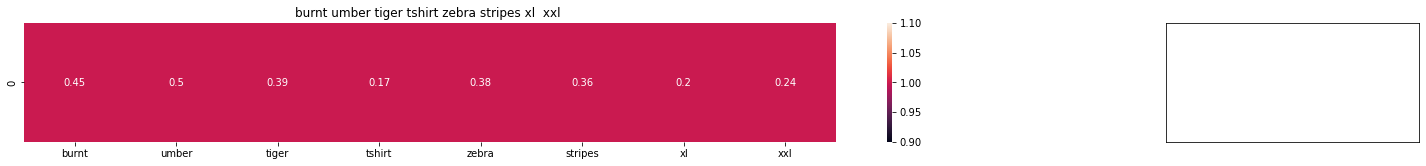

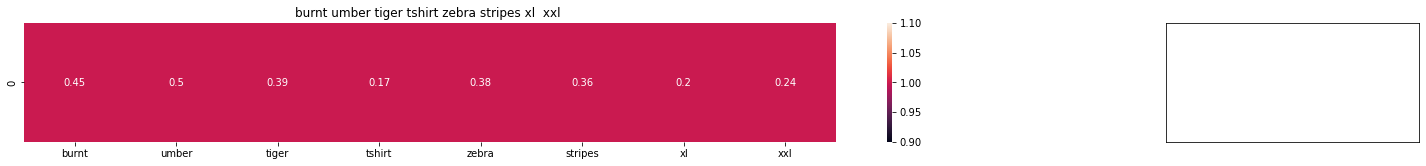

ASIN : B00JXQB5FQ
BRAND : Si Row
Eucliden distance from the given image : 0.0


'https://images-na.ssl-images-amazon.com/images/I/51idp4BP50L._SL160_.jpg'

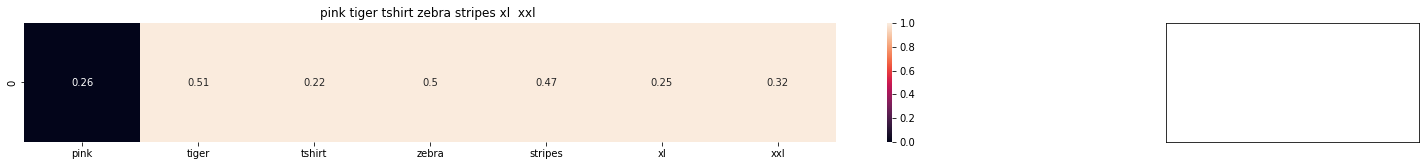

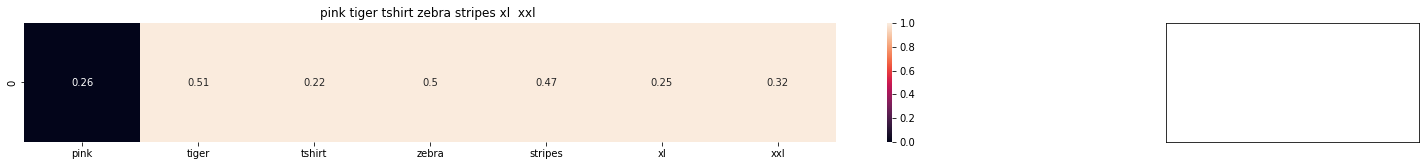

ASIN : B00JXQASS6
BRAND : Si Row
Eucliden distance from the given image : 0.7536331912451363


'https://images-na.ssl-images-amazon.com/images/I/51tOiBaq5FL._SL160_.jpg'

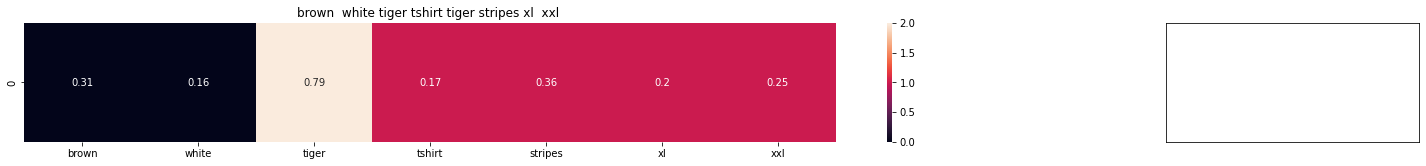

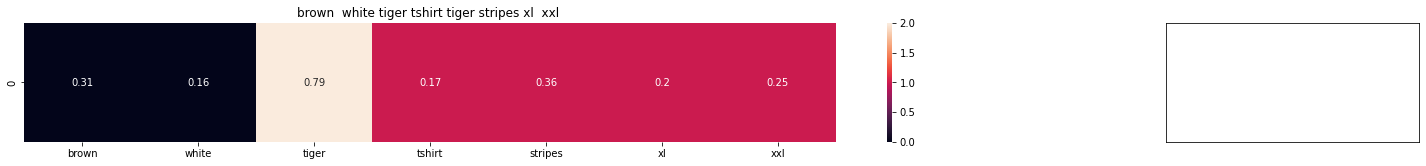

ASIN : B00JXQCWTO
BRAND : Si Row
Eucliden distance from the given image : 0.9357643943769647


'https://images-na.ssl-images-amazon.com/images/I/51WmlCKqC-L._SL160_.jpg'

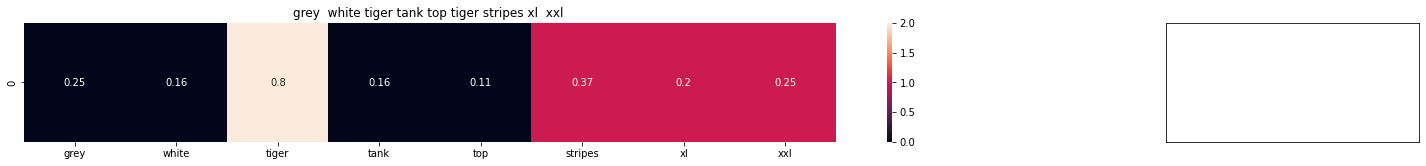

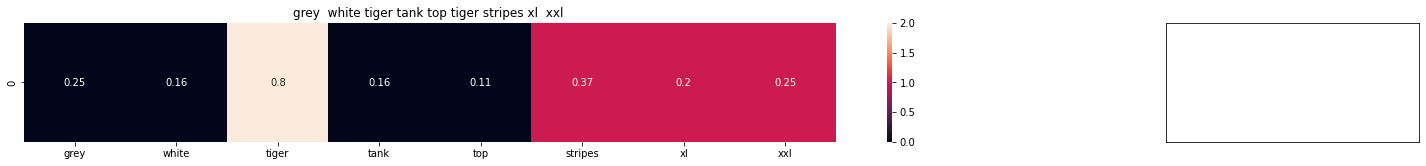

ASIN : B00JXQAFZ2
BRAND : Si Row
Eucliden distance from the given image : 0.9586153524200749


'https://images-na.ssl-images-amazon.com/images/I/511SmrC%2BS1L._SL160_.jpg'

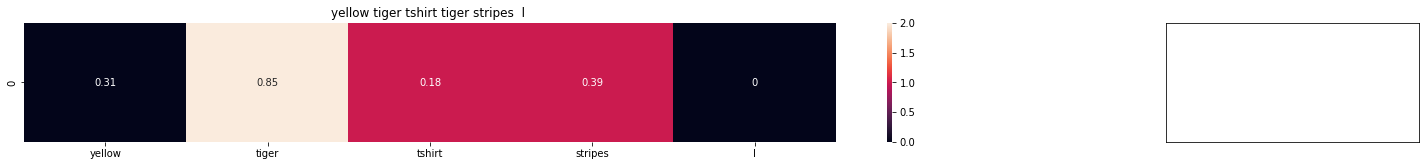

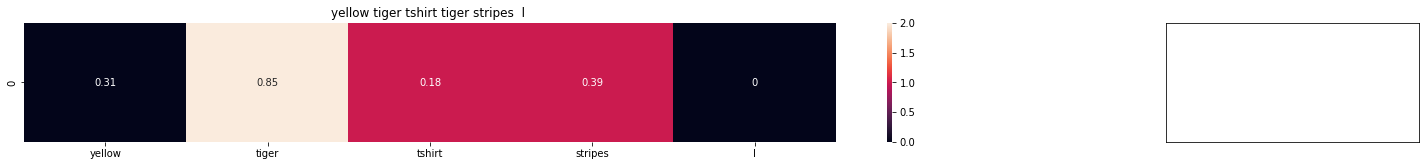

ASIN : B00JXQCUIC
BRAND : Si Row
Eucliden distance from the given image : 1.000074961446881


'https://images-na.ssl-images-amazon.com/images/I/51YtMh1qC5L._SL160_.jpg'

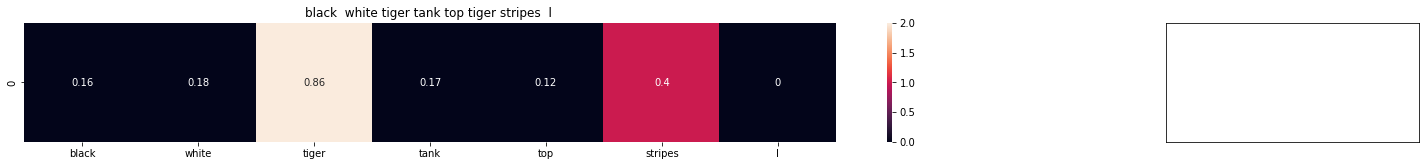

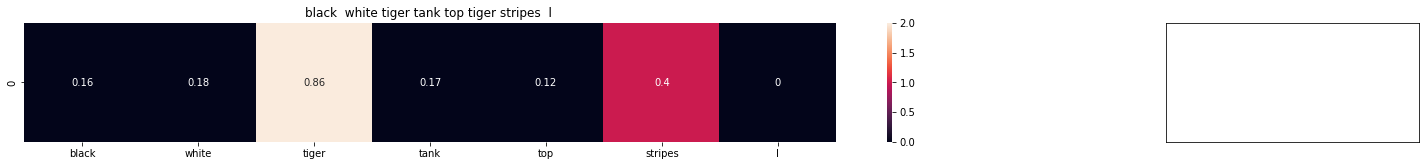

ASIN : B00JXQAO94
BRAND : Si Row
Eucliden distance from the given image : 1.023215552457452


'https://images-na.ssl-images-amazon.com/images/I/51VrT%2BmJ15L._SL160_.jpg'

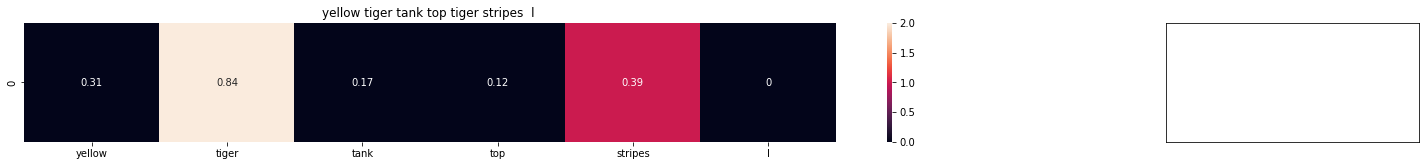

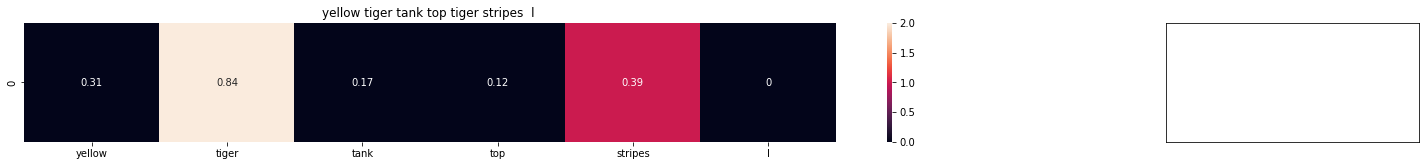

ASIN : B00JXQAUWA
BRAND : Si Row
Eucliden distance from the given image : 1.031991846303421


'https://images-na.ssl-images-amazon.com/images/I/41xG4P296RL._SL160_.jpg'

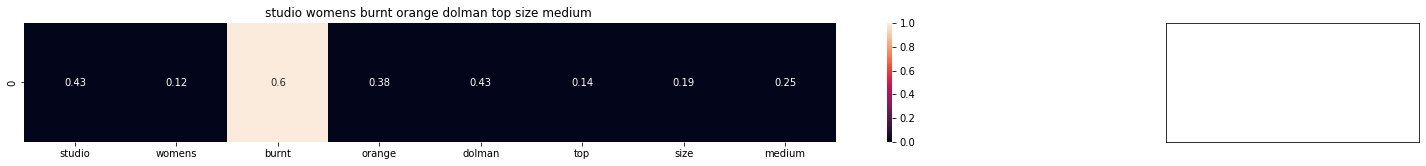

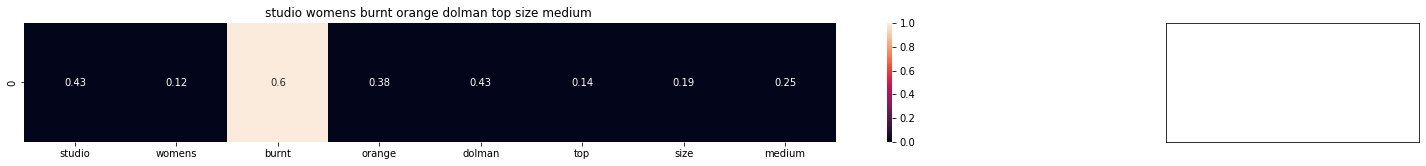

ASIN : B06XSCVFT5
BRAND : Studio M
Eucliden distance from the given image : 1.2106843670424716


'https://images-na.ssl-images-amazon.com/images/I/41xUwhNnWSL._SL160_.jpg'

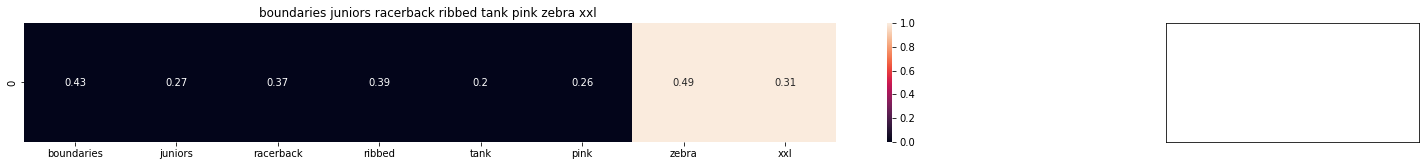

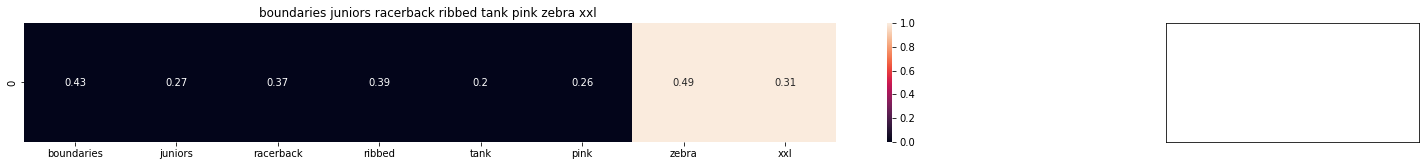

ASIN : B06Y2GTYPM
BRAND : No Boundaries
Eucliden distance from the given image : 1.2121683810720831


'https://images-na.ssl-images-amazon.com/images/I/51XBEBD-tUL._SL160_.jpg'

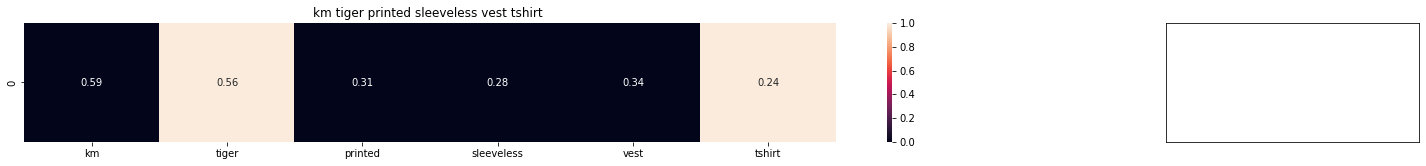

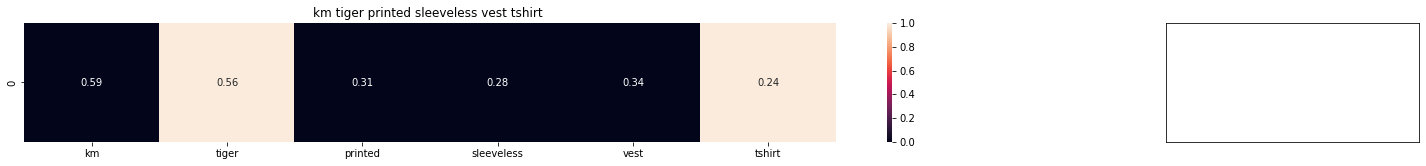

ASIN : B012VQLT6Y
BRAND : KM T-shirt
Eucliden distance from the given image : 1.219790640280982


'https://images-na.ssl-images-amazon.com/images/I/41vz98TeJLL._SL160_.jpg'

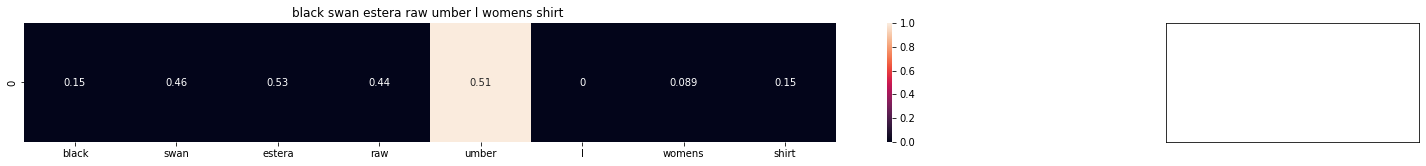

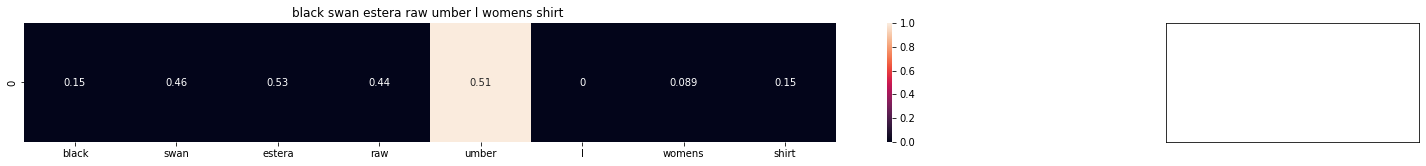

ASIN : B06Y1VN8WQ
BRAND : Black Swan
Eucliden distance from the given image : 1.2206849659998316


'https://images-na.ssl-images-amazon.com/images/I/41tqMgWPb0L._SL160_.jpg'

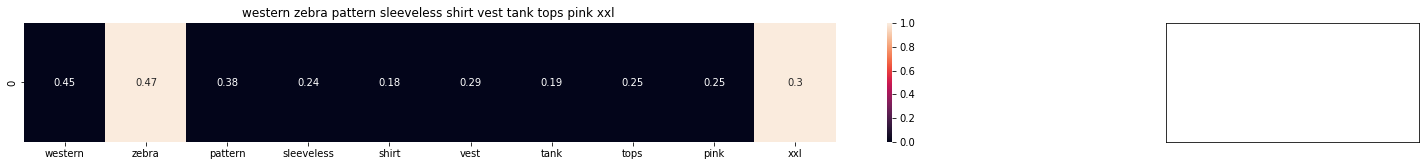

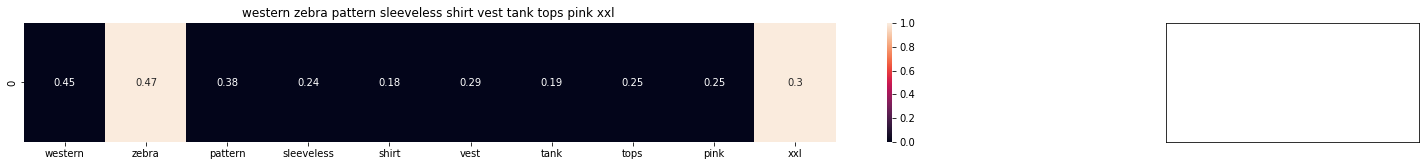

ASIN : B00Z6HEXWI
BRAND : Black Temptation
Eucliden distance from the given image : 1.221281392120943


'https://images-na.ssl-images-amazon.com/images/I/41OMPsit5mL._SL160_.jpg'

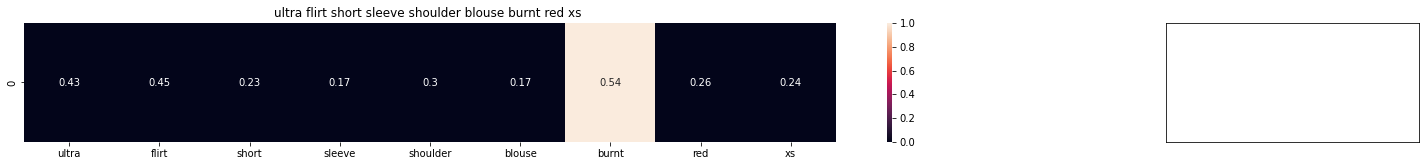

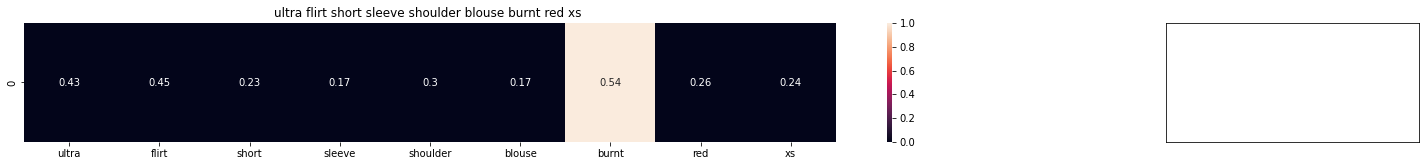

ASIN : B074TR12BH
BRAND : Ultra Flirt
Eucliden distance from the given image : 1.2313364094597743


'https://images-na.ssl-images-amazon.com/images/I/61z94VfdrsL._SL160_.jpg'

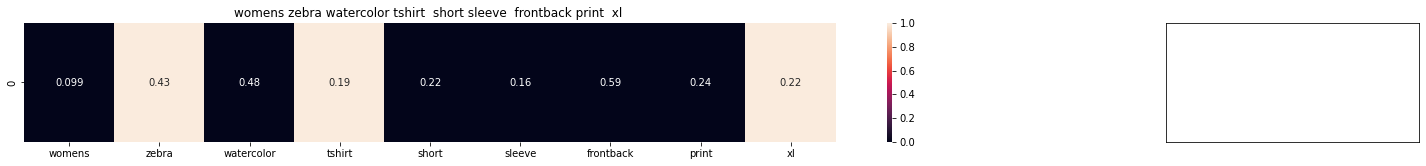

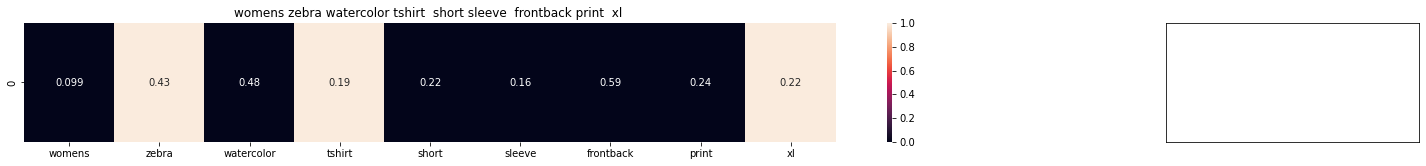

ASIN : B072R2JXKW
BRAND : WHAT ON EARTH
Eucliden distance from the given image : 1.2318451972624516


'https://images-na.ssl-images-amazon.com/images/I/41W15g8czdL._SL160_.jpg'

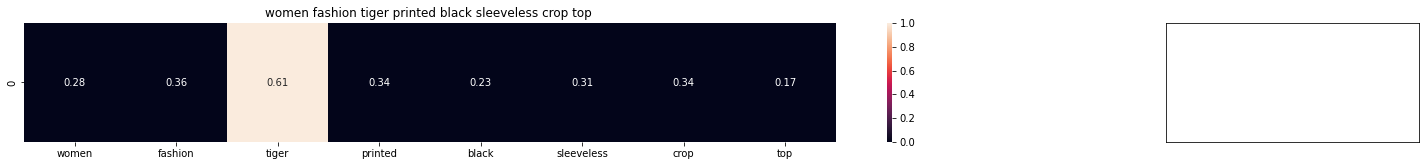

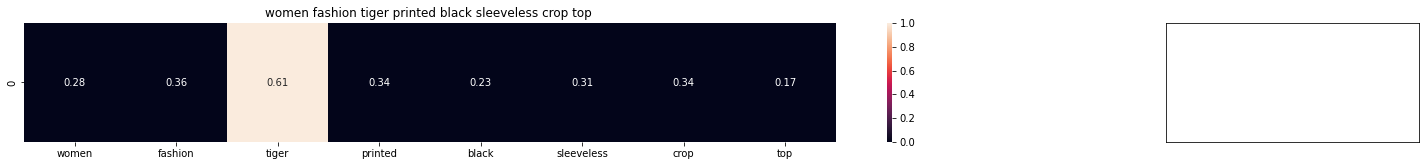

ASIN : B074T8ZYGX
BRAND : MKP Crop Top
Eucliden distance from the given image : 1.2340607457359425


'https://images-na.ssl-images-amazon.com/images/I/41mR1Ujv7BL._SL160_.jpg'

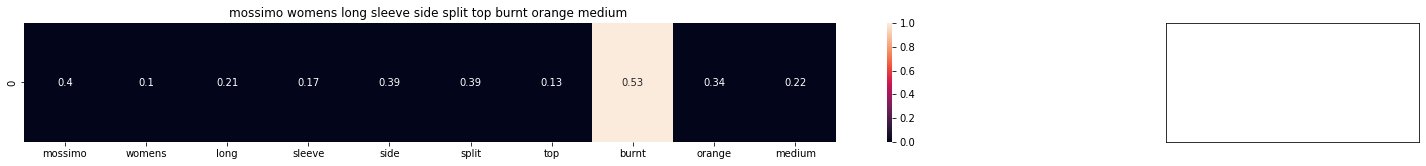

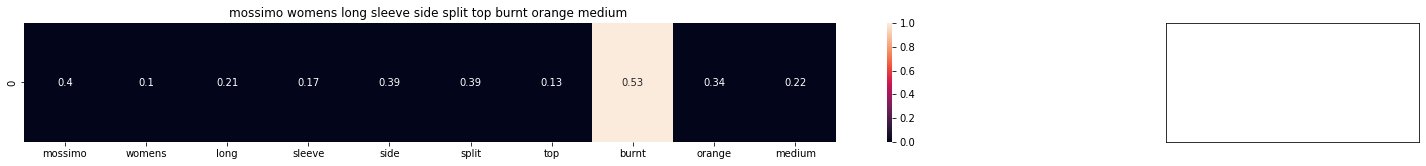

ASIN : B071ZDF6T2
BRAND : Mossimo
Eucliden distance from the given image : 1.2352785577664824


'https://images-na.ssl-images-amazon.com/images/I/51HpZBwpSiL._SL160_.jpg'

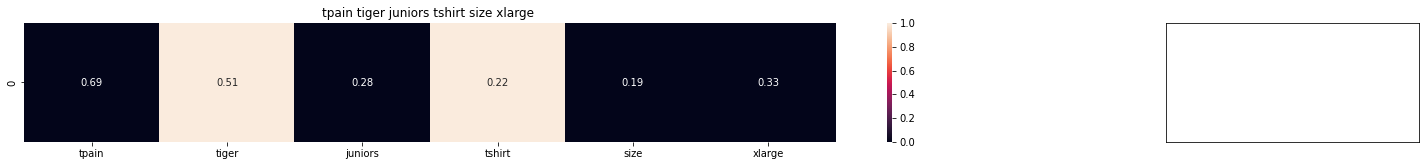

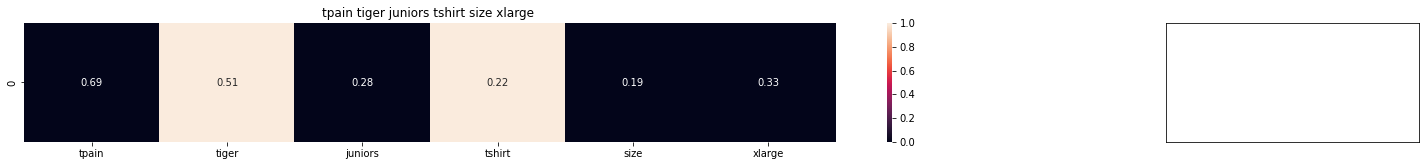

ASIN : B01K0H02OG
BRAND : Tultex
Eucliden distance from the given image : 1.236457298812782


'https://images-na.ssl-images-amazon.com/images/I/41vaIqe7CwL._SL160_.jpg'

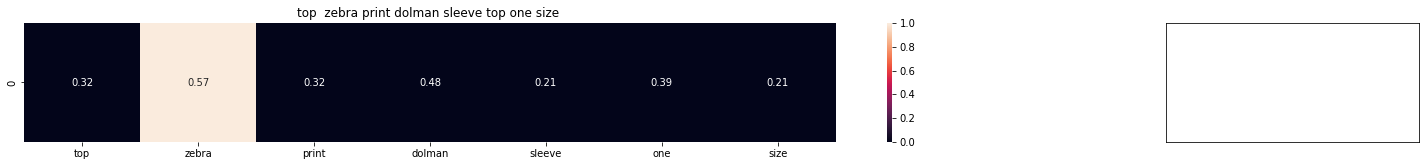

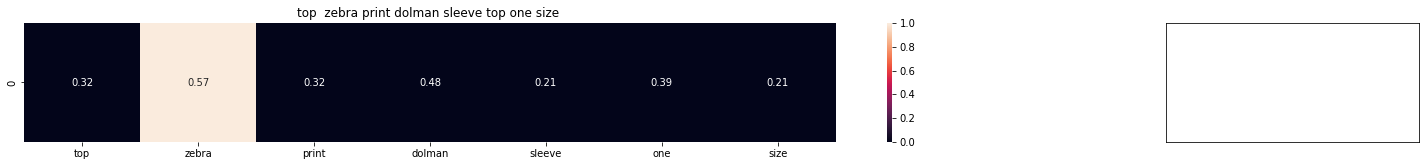

ASIN : B00H8A6ZLI
BRAND : Vivian's Fashions
Eucliden distance from the given image : 1.24996155052848


'https://images-na.ssl-images-amazon.com/images/I/513omXMEbpL._SL160_.jpg'

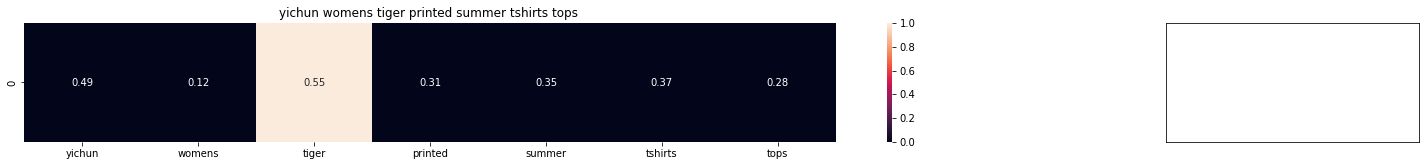

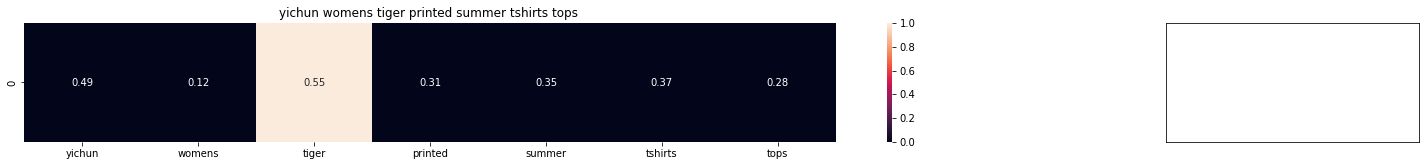

ASIN : B010NN9RXO
BRAND : YICHUN
Eucliden distance from the given image : 1.2535461420856102


'https://images-na.ssl-images-amazon.com/images/I/51%2BtEnckltL._SL160_.jpg'

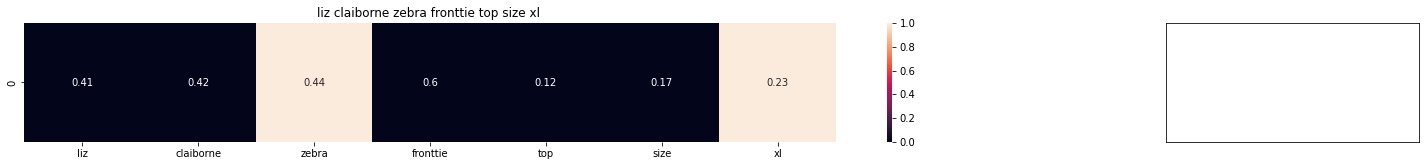

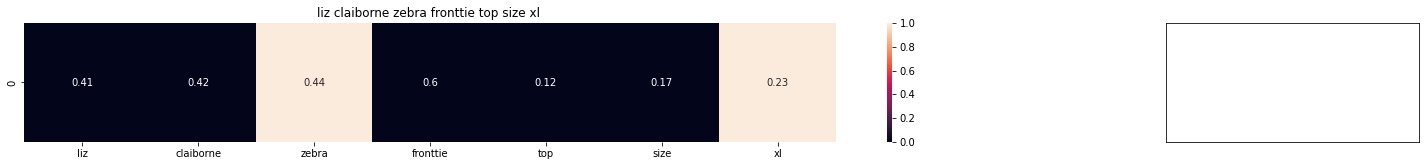

ASIN : B06XBY5QXL
BRAND : Liz Claiborne
Eucliden distance from the given image : 1.2538832938357722


In [ ]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 20)
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title